In [5]:
import sys
from qiskit_aer.noise import phase_amplitude_damping_error, depolarizing_error

sys.path.append("..")


from experiments.plt_pab_fae import plt_fab_fae
from protocol.BB84EveTrainableProtocol import BB84EveTrainableProtocol
from protocol.BB84TrainableProtocol import BB84TrainableProtocol
from protocol.connection_elements.Layer import SeparableLayer, EntangledLayer
from protocol.BB84Protocol import BB84Protocol
from protocol.connection_elements.MultiQubitQCLEve import MultiQubitQCLEve
from protocol.connection_elements.Noise import Noise



No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


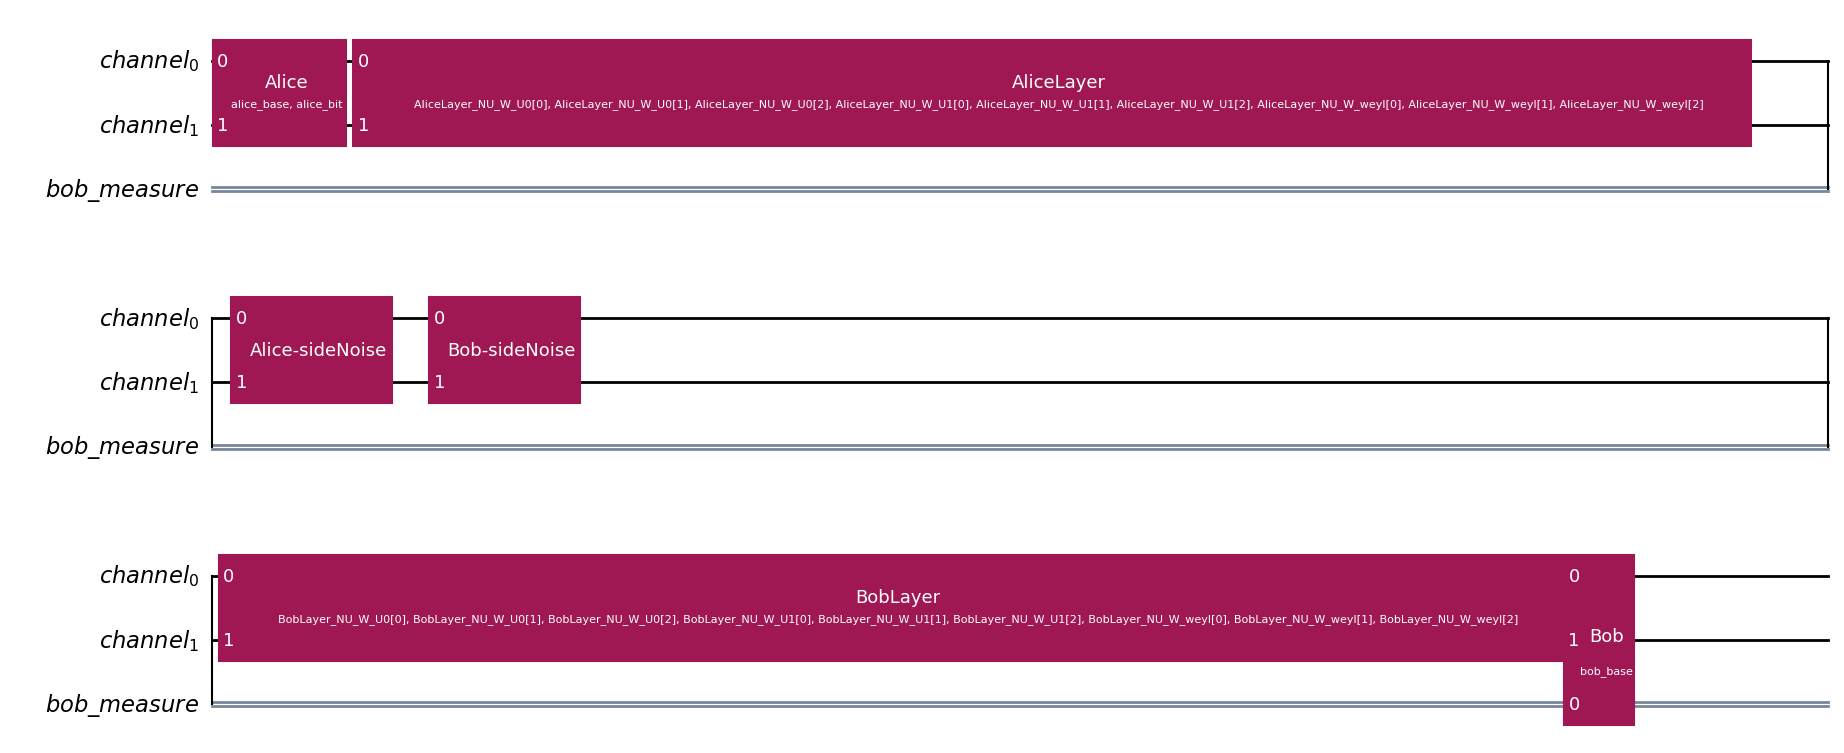

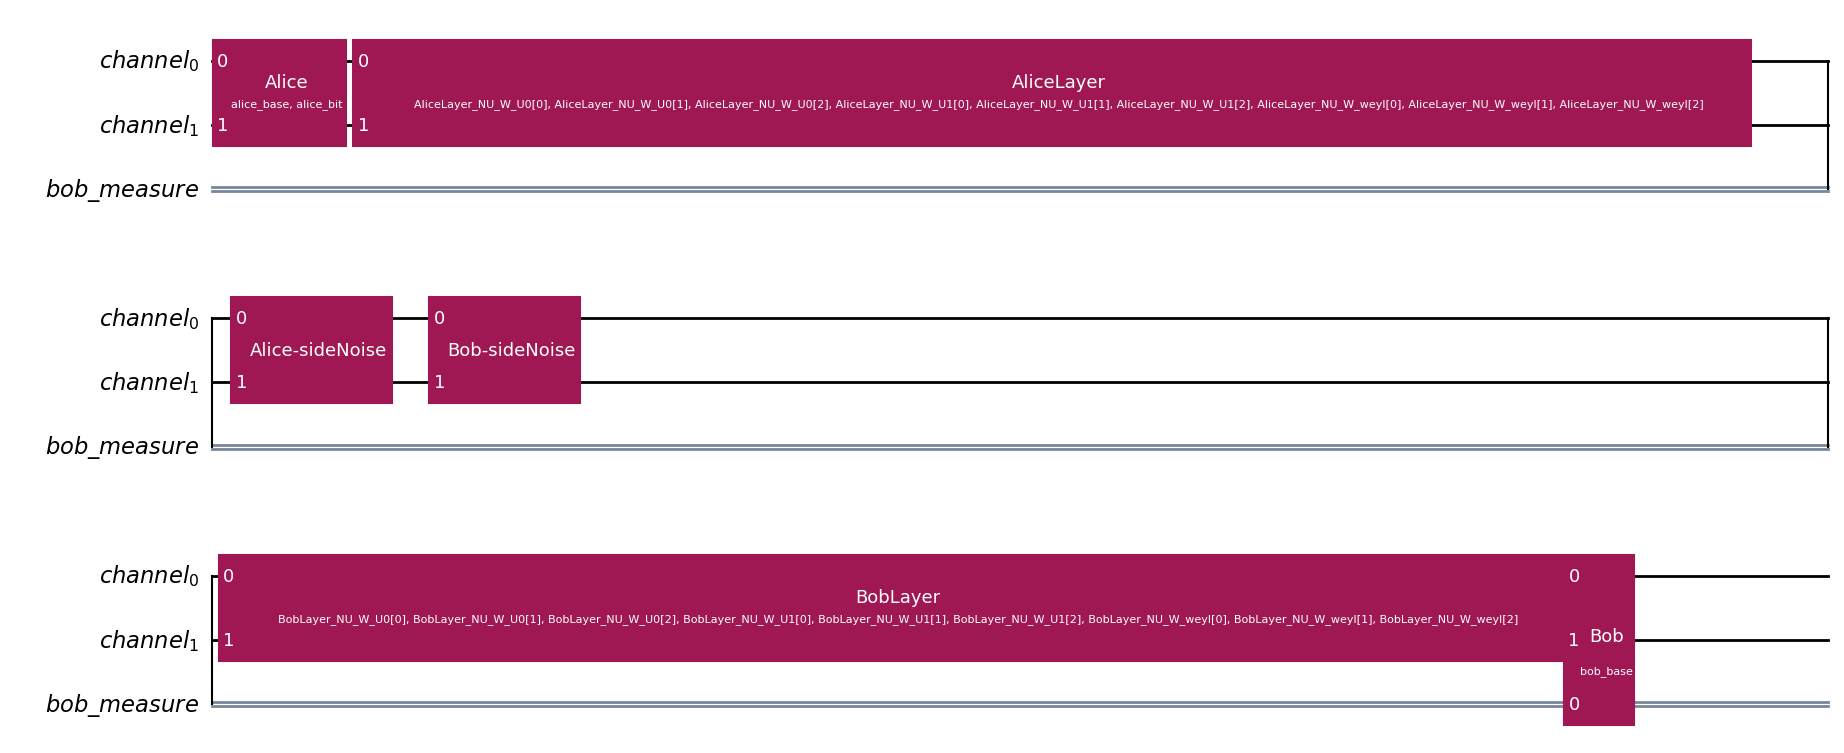

In [6]:
layers = [EntangledLayer("AliceLayer"), EntangledLayer("BobLayer")]
noises = [Noise(phase_amplitude_damping_error(0.1, 0.1), "Alice-sideNoise"),
          Noise(phase_amplitude_damping_error(0.1, 0.1), "Bob-sideNoise")]
eve = MultiQubitQCLEve()
elements_no_eve = [layers[0], noises[0], noises[1],layers[1]]
elements_eve = [layers[0], noises[0], eve, noises[1],layers[1]]

ab_protocol = BB84TrainableProtocol(n_bits=512, elements=elements_no_eve, channel_size=2, seed=0, learning_rate=0.1)
eve_protocol = BB84EveTrainableProtocol(n_bits=512, elements=elements_eve, channel_size=2,
                                        seed=0, alpha=1, learning_rate=0.05)

qc, _ = ab_protocol.qc_with_ctx()
qc.draw("mpl", expr_len=3)

In [7]:
def train_eve():
    bob_qber, eve_qber = [], []
    qber = eve_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(qber['eve_qber'])
    print(f'start QBER: {qber}')
    for epoch in range(50):
        loss = eve_protocol.train()
        qber = eve_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(qber['eve_qber'])
        if epoch % 5 == 0 or epoch == 49:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

def train_ab():
    bob_qber, eve_qber = [], []
    qber = ab_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(0.5)
    print(f'start QBER: {qber}')
    for epoch in range(20):
        loss = ab_protocol.train()
        qber = ab_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(0.5)
        if epoch % 5 == 0 or epoch == 19:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

# Krok 1 - trenowanie Alice i Boba do początkowego stanu
Uczymy Alice i Boba bez Eve, aby miały sensowne parametry początkowe i potrafiły przekazywać sobie dane.

In [8]:
b_q, e_q = train_ab()

start QBER: {'bob_qber': np.float64(0.45679012345679015)}
epoch: 0, loss: -0.5486723780632019, QBER: {'bob_qber': np.float64(0.32098765432098764)}
epoch: 5, loss: -0.8394468426704407, QBER: {'bob_qber': np.float64(0.18518518518518523)}
epoch: 10, loss: -0.8728690147399902, QBER: {'bob_qber': np.float64(0.13168724279835387)}
epoch: 15, loss: -0.8857237100601196, QBER: {'bob_qber': np.float64(0.13168724279835387)}
epoch: 19, loss: -0.8963515162467957, QBER: {'bob_qber': np.float64(0.13580246913580252)}


<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

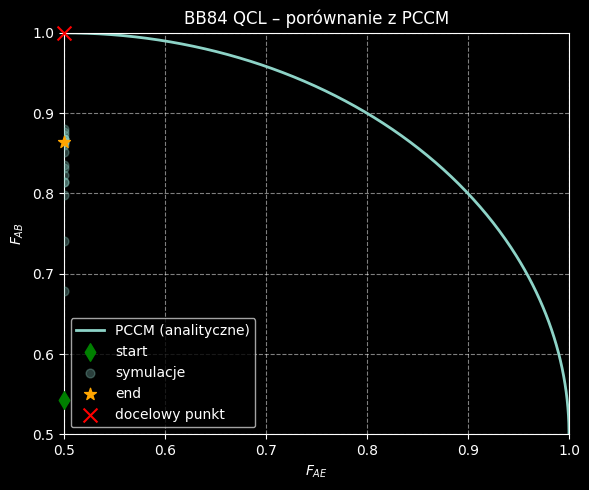

In [9]:
plt_fab_fae(b_q, e_q, 1)

# Krok 2 - trenowanie tylko Eve, warstwy Alice i Boba zamrożone
Uczymy samą Eve, docelowa dokładność Boba to 0.8. Startujemy od parametrów Alice i Boba wytrenowanych w poprzednim kroku i Eve jako identyczność.

In [ ]:
eve_protocol.set_parameters(ab_protocol.get_all_parameters())

params = eve_protocol.get_all_parameters()
for p in eve.trainable_parameters():
    k = p.name
    params[k] = 0

eve_protocol.set_parameters(params)
eve_protocol.freeze_elements(layers)

In [11]:
eve_protocol.f_value = 0.8
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.09701492537313428), 'eve_qber': np.float64(0.5037313432835822)}
epoch: 0, loss: -0.7395981550216675, QBER: {'bob_qber': np.float64(0.09701492537313428), 'eve_qber': np.float64(0.5037313432835822)}
epoch: 5, loss: -0.7451363205909729, QBER: {'bob_qber': np.float64(0.09701492537313428), 'eve_qber': np.float64(0.4776119402985075)}
epoch: 10, loss: -0.7624025940895081, QBER: {'bob_qber': np.float64(0.09328358208955223), 'eve_qber': np.float64(0.48134328358208955)}
epoch: 15, loss: -0.7664141654968262, QBER: {'bob_qber': np.float64(0.09701492537313428), 'eve_qber': np.float64(0.4925373134328358)}
epoch: 20, loss: -0.7477048635482788, QBER: {'bob_qber': np.float64(0.09701492537313428), 'eve_qber': np.float64(0.5)}
epoch: 25, loss: -0.7786369323730469, QBER: {'bob_qber': np.float64(0.09701492537313428), 'eve_qber': np.float64(0.5)}
epoch: 30, loss: -0.7999745011329651, QBER: {'bob_qber': np.float64(0.09701492537313428), 'eve_qber': np.float64(0.4776119402

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

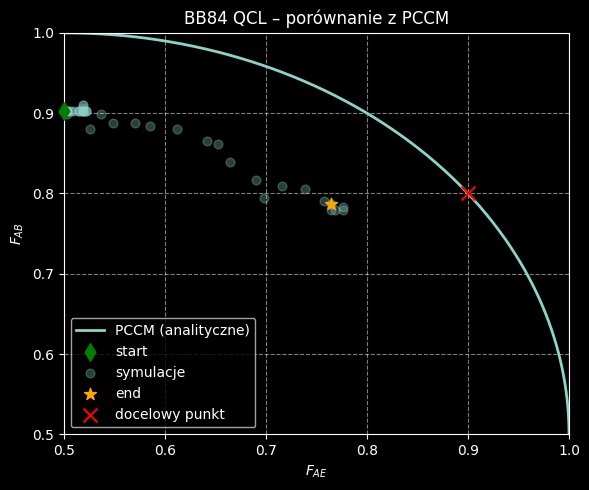

In [12]:
plt_fab_fae(b_q, e_q, 0.8)

# Krok 3 - trenowanie warstw Alice i Boba, Eve zamrożona
Próbujemy uczyć Alice i Boba z użyciem nowej funkcji straty, która maksymalizuje jedynie dokładność Boba.

In [14]:
eve_protocol.freeze_elements([eve])
eve_loss = eve_protocol.loss
eve_protocol.loss = ab_protocol.loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.2126865671641791), 'eve_qber': np.float64(0.2350746268656716)}
epoch: 0, loss: -0.7905327677726746, QBER: {'bob_qber': np.float64(0.21641791044776115), 'eve_qber': np.float64(0.26119402985074625)}
epoch: 5, loss: -0.8056468367576599, QBER: {'bob_qber': np.float64(0.18283582089552242), 'eve_qber': np.float64(0.3171641791044776)}
epoch: 10, loss: -0.8279821276664734, QBER: {'bob_qber': np.float64(0.19029850746268662), 'eve_qber': np.float64(0.3619402985074627)}
epoch: 15, loss: -0.8156476020812988, QBER: {'bob_qber': np.float64(0.20149253731343286), 'eve_qber': np.float64(0.3805970149253731)}
epoch: 20, loss: -0.8174208402633667, QBER: {'bob_qber': np.float64(0.17910447761194026), 'eve_qber': np.float64(0.3731343283582089)}
epoch: 25, loss: -0.8289569616317749, QBER: {'bob_qber': np.float64(0.17164179104477617), 'eve_qber': np.float64(0.35820895522388063)}
epoch: 30, loss: -0.8266643285751343, QBER: {'bob_qber': np.float64(0.16417910447761197), 'eve_

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

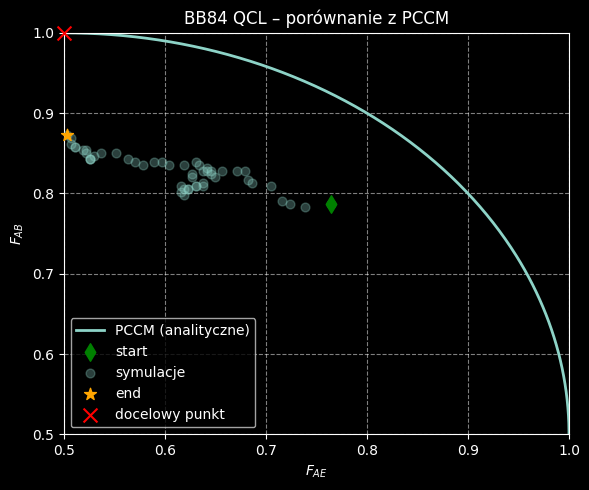

In [15]:
plt_fab_fae(b_q, e_q, 1)

In [17]:
eve_protocol.freeze_elements(layers)
eve_protocol.f_value = 0.8
eve_protocol.loss = eve_loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.12686567164179108), 'eve_qber': np.float64(0.49626865671641796)}
epoch: 0, loss: -0.7442409992218018, QBER: {'bob_qber': np.float64(0.12686567164179108), 'eve_qber': np.float64(0.4477611940298507)}
epoch: 5, loss: -0.8621240258216858, QBER: {'bob_qber': np.float64(0.16044776119402981), 'eve_qber': np.float64(0.3246268656716418)}
epoch: 10, loss: -0.8981881141662598, QBER: {'bob_qber': np.float64(0.19402985074626866), 'eve_qber': np.float64(0.2425373134328358)}
epoch: 15, loss: -0.9069581031799316, QBER: {'bob_qber': np.float64(0.2052238805970149), 'eve_qber': np.float64(0.2574626865671642)}
epoch: 20, loss: -0.9118548631668091, QBER: {'bob_qber': np.float64(0.19402985074626866), 'eve_qber': np.float64(0.26119402985074625)}
epoch: 25, loss: -0.9264805912971497, QBER: {'bob_qber': np.float64(0.19402985074626866), 'eve_qber': np.float64(0.23880597014925375)}
epoch: 30, loss: -0.9305601716041565, QBER: {'bob_qber': np.float64(0.20895522388059706), 'eve

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

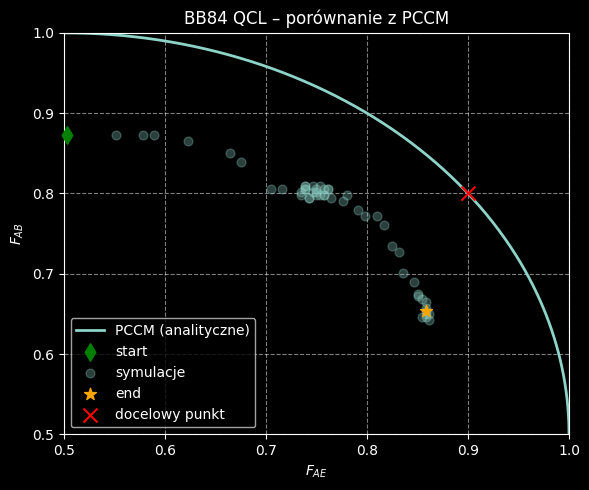

In [18]:
plt_fab_fae(b_q, e_q, 0.8)

In [20]:
eve_protocol.freeze_elements([eve])
eve_protocol.loss = ab_protocol.loss
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.3470149253731343), 'eve_qber': np.float64(0.14179104477611937)}
epoch: 0, loss: -0.6871231198310852, QBER: {'bob_qber': np.float64(0.31343283582089554), 'eve_qber': np.float64(0.16791044776119401)}
epoch: 5, loss: -0.7341926097869873, QBER: {'bob_qber': np.float64(0.25), 'eve_qber': np.float64(0.2201492537313433)}
epoch: 10, loss: -0.7878801822662354, QBER: {'bob_qber': np.float64(0.18283582089552242), 'eve_qber': np.float64(0.3171641791044776)}
epoch: 15, loss: -0.8148728609085083, QBER: {'bob_qber': np.float64(0.15298507462686572), 'eve_qber': np.float64(0.41417910447761197)}
epoch: 20, loss: -0.8278677463531494, QBER: {'bob_qber': np.float64(0.14552238805970152), 'eve_qber': np.float64(0.4701492537313433)}
epoch: 25, loss: -0.8424864411354065, QBER: {'bob_qber': np.float64(0.12313432835820892), 'eve_qber': np.float64(0.5037313432835822)}
epoch: 30, loss: -0.8458089828491211, QBER: {'bob_qber': np.float64(0.12686567164179108), 'eve_qber': np.floa

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

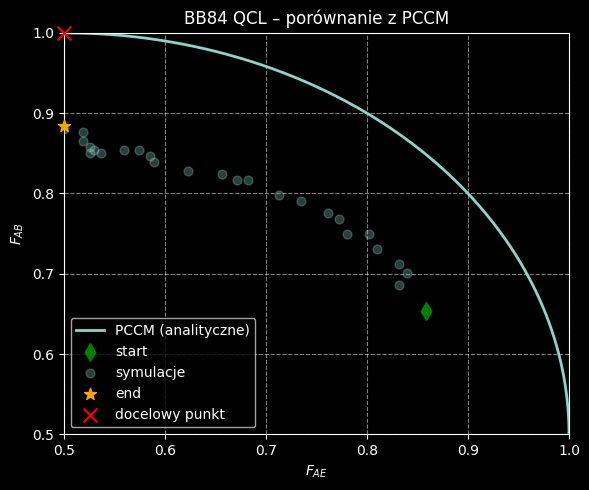

In [21]:
plt_fab_fae(b_q, e_q, 1)

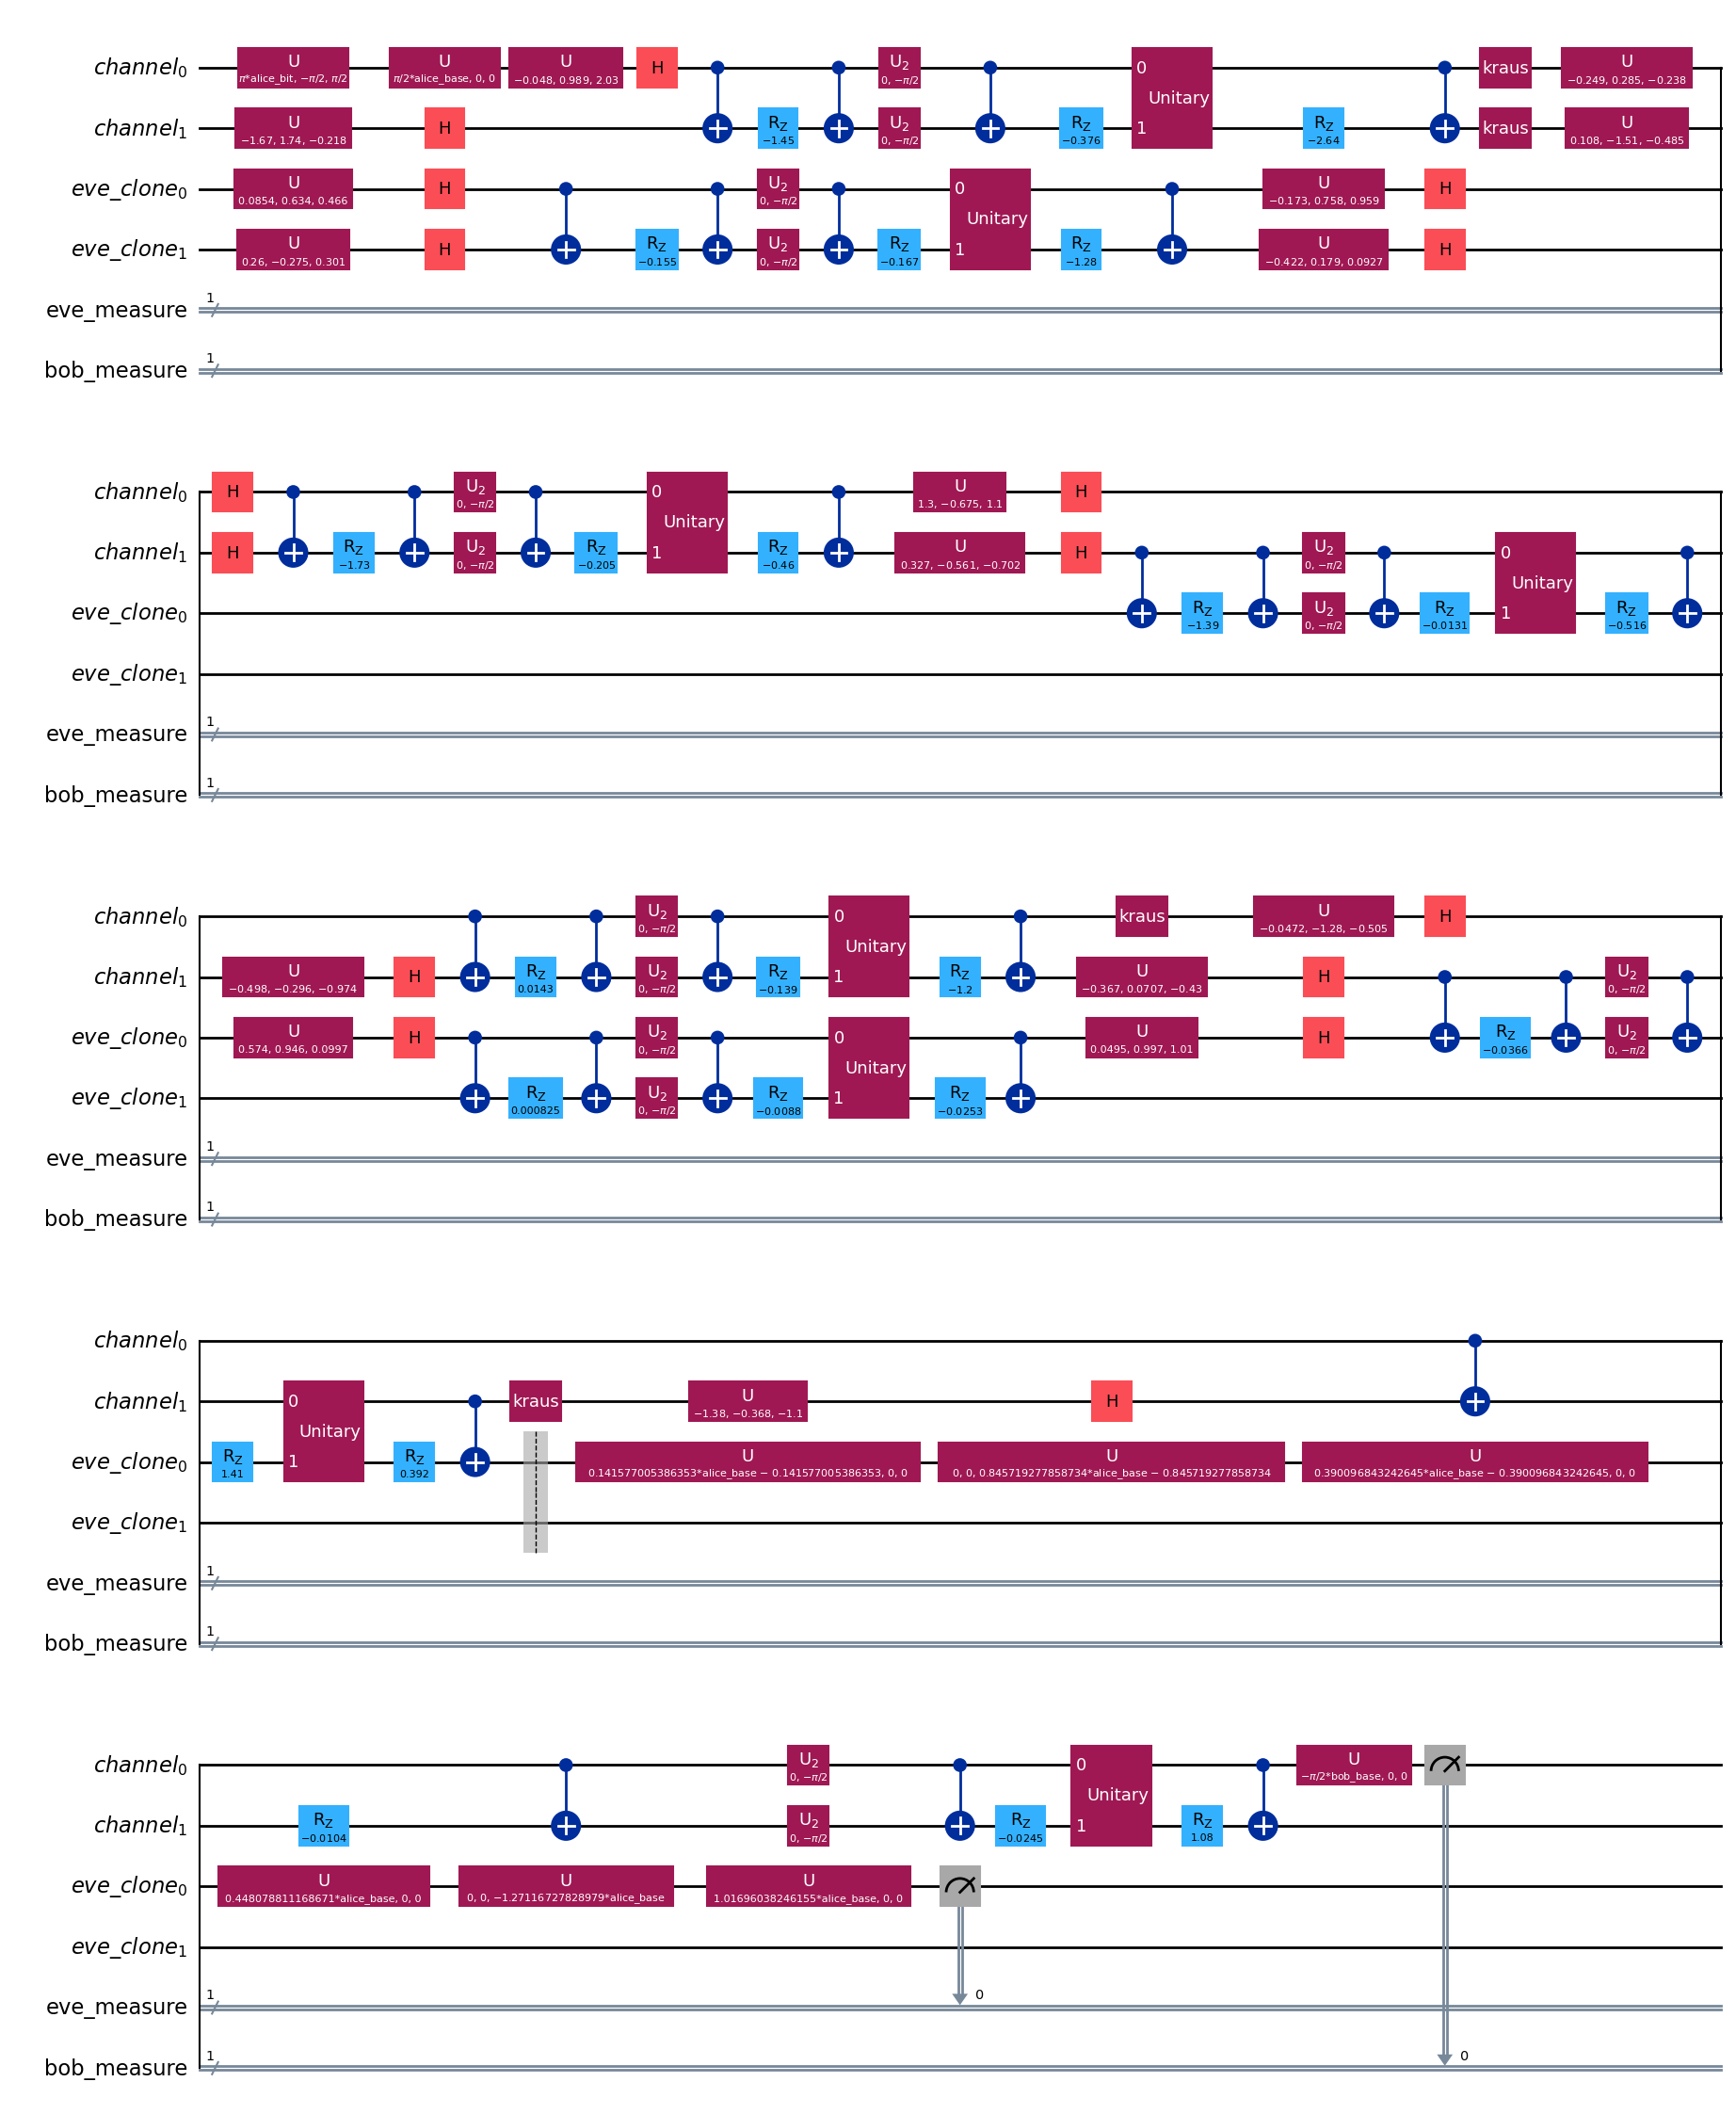

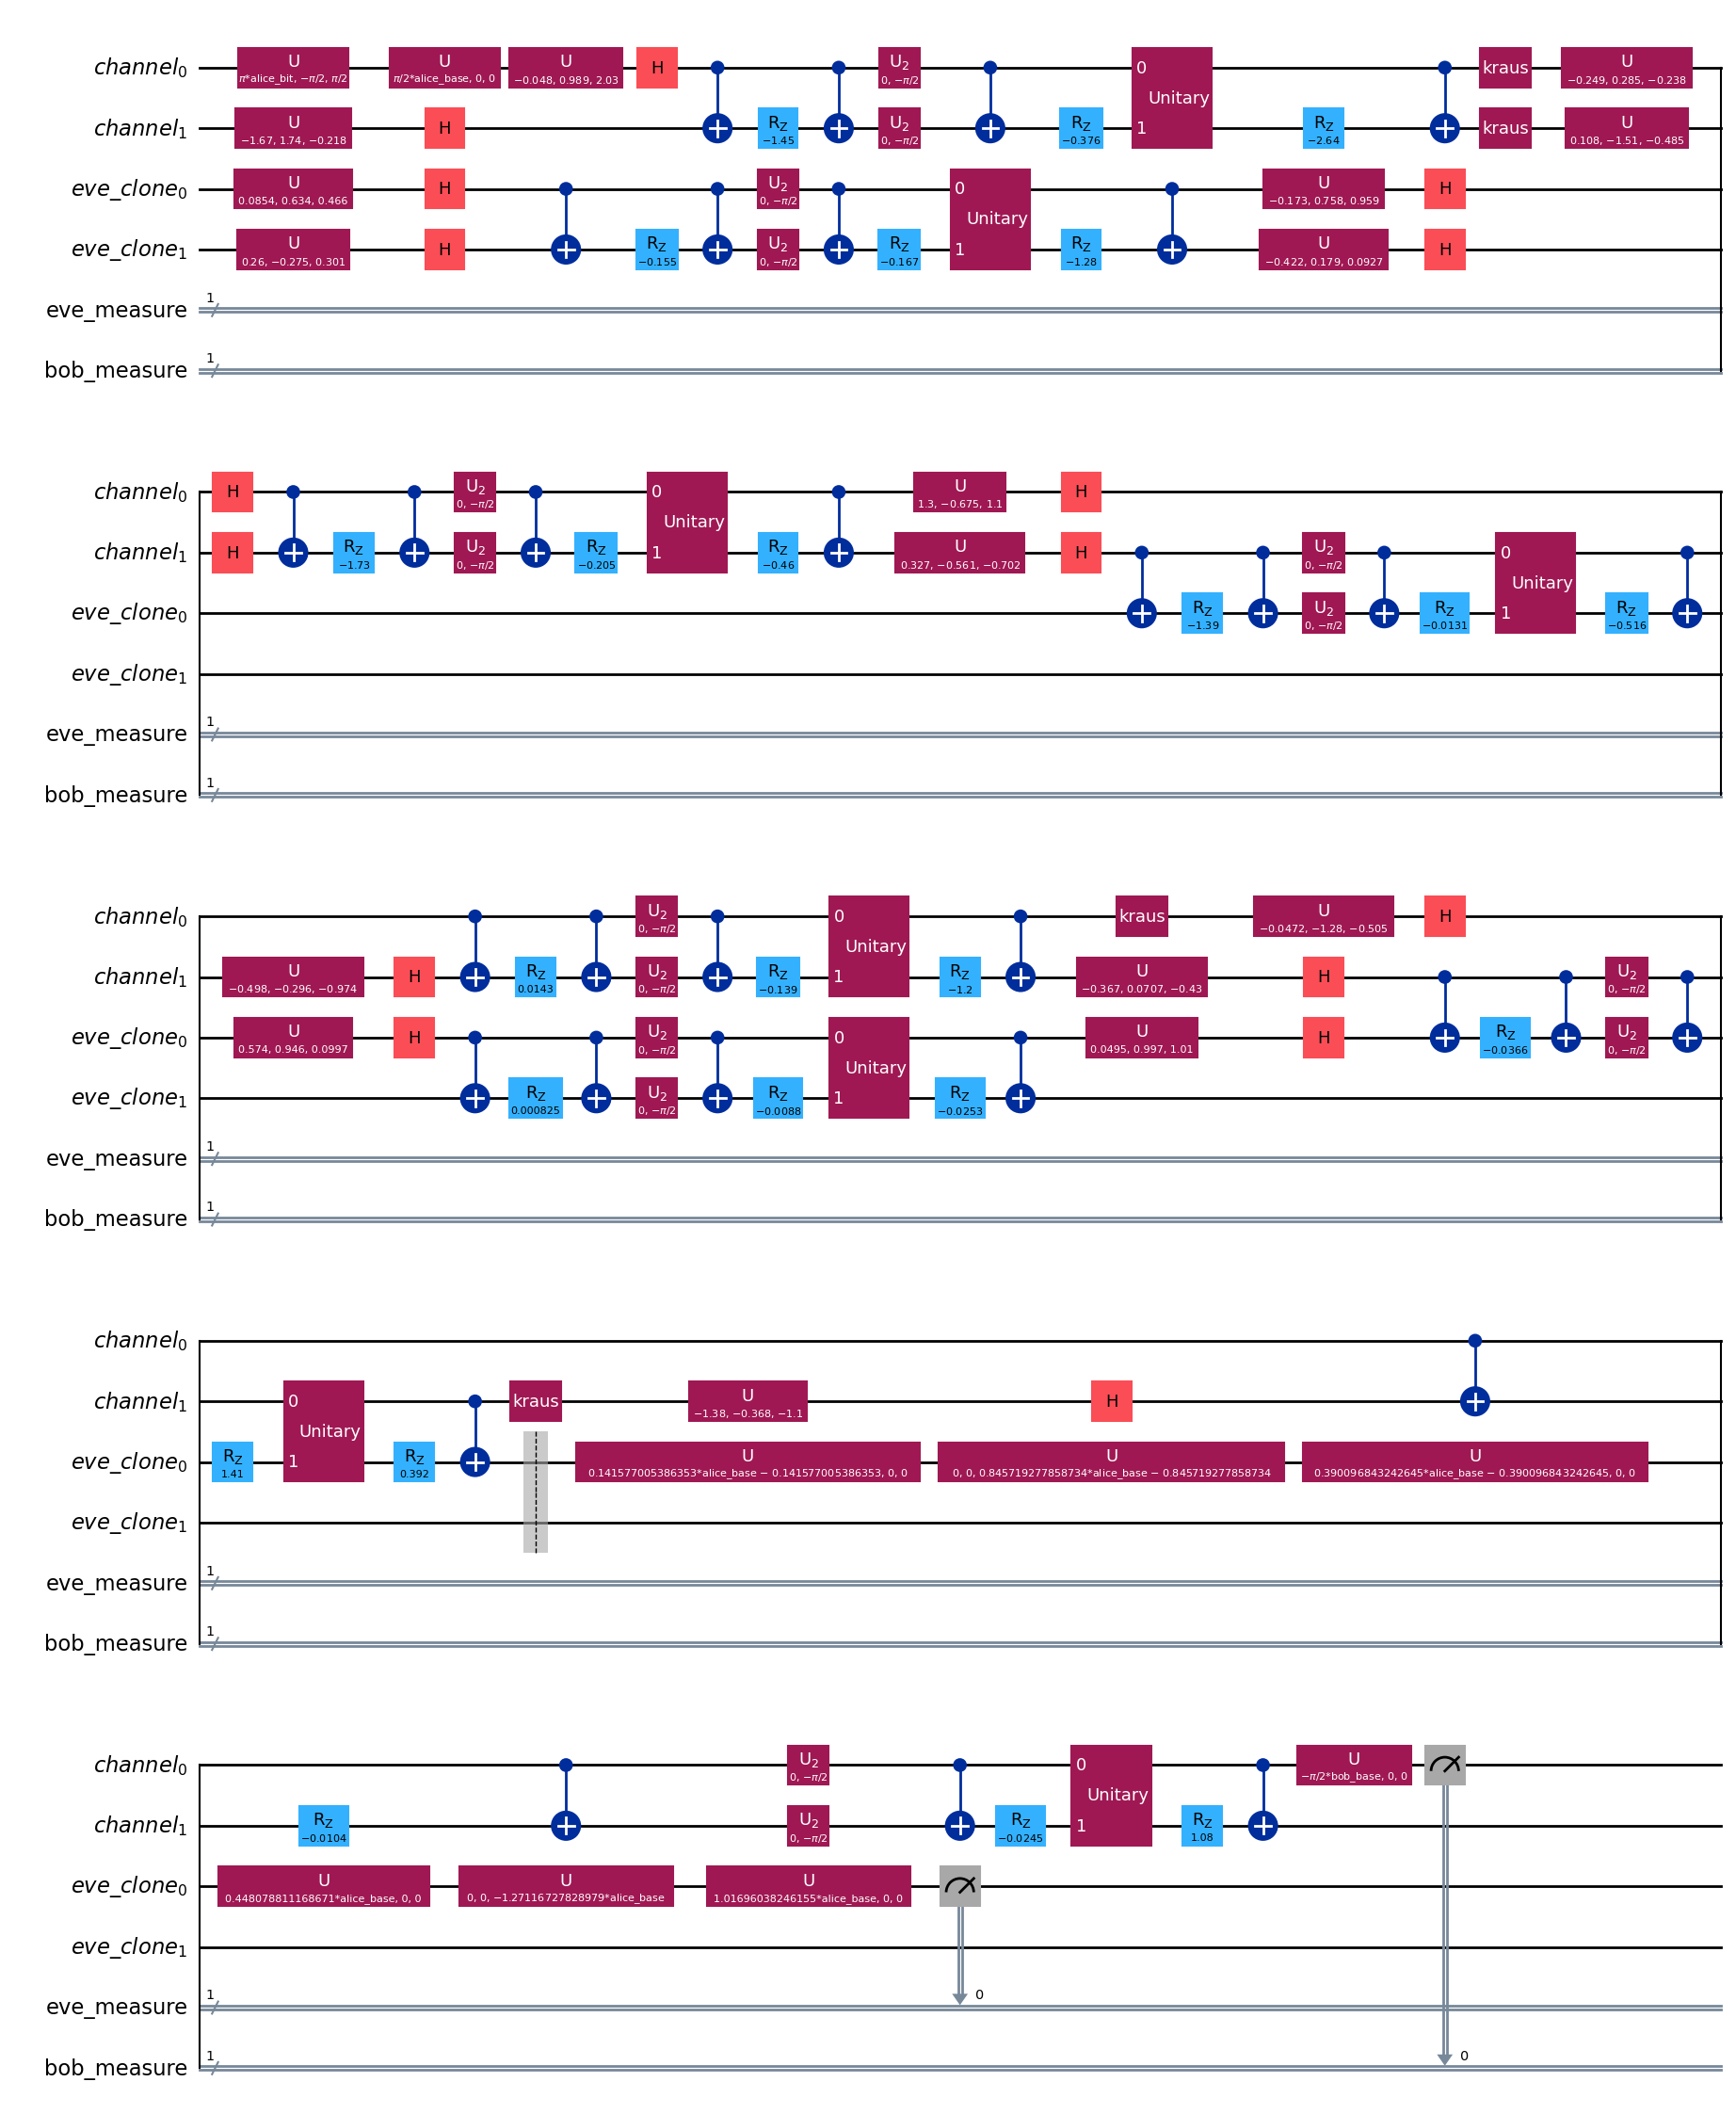

In [23]:
eve_protocol._qc.assign_parameters(eve_protocol.get_all_parameters()).draw("mpl")